In this scenario, we have a number of validators. Each slot, a validator is chosen from the set at random, to receive a fixed block reward, and a fixed MEV reward. The fixed reward is set at 0.025ETH, while the fixed MEV reward is set at 0.1ETH. The simulation is run 300,000 times, each run representing one slot. Therefore, the total runs represent how rewards accrue over approximately a year.

Each validator belongs to an entity, with ten entities in total. The significance of entities for this scenario is that rewards will be counted per entity as well. After each slot, the total of rewards per entity is checked. If it is greater or equal to 64 eth, a new validator will be spawned and added to the validator set, for that same entity. In this way, one of the key assumptions of this set of simulations is that validators will automatically reinvest any profits that they get into new validators.

The block below sets up the simulation parameters. We choose ten entities to start, although this could be revised up or down, with the validator set split evenly between these entities. The number of validators and the number of slots are set to represent the approximate number of Eth validators live on mainnet right now, and the approximate number of slots in a year. The fixed block and MEV rewards are representative of average block and MEV rewards.

In [9]:
import numpy as np
import random

num_entities = 100
num_validators = 50000
num_slots = 30000
fixed_reward = 0.025
fixed_mev_reward = 0.1
split_threshold = 32

# Create validator_entity_mapping and initialize rewards
validator_entity_mapping = [i % num_entities for i in range(num_validators)]
validator_rewards = np.zeros(num_validators)
entity_rewards = np.zeros(num_entities)

# Create lists of validators per entity
validators_per_entity = [[] for _ in range(num_entities)]
for validator_idx, entity in enumerate(validator_entity_mapping):
    validators_per_entity[entity].append(validator_idx)


The next section runs the simulation. As mentioned above, as soon as 32eth has accrued for a specific entity, a new validator will be added to the validator set for that entity.

In [10]:
# Run the simulation
for _ in range(num_slots):
    # Select a random validator
    chosen_validator = random.randrange(num_validators)

    # Assign rewards
    block_reward = fixed_reward
    mev_reward = fixed_mev_reward
    total_reward = block_reward + mev_reward

    validator_rewards[chosen_validator] += total_reward
    entity_rewards[validator_entity_mapping[chosen_validator]] += total_reward

    # Check if we need to spawn a new validator for any entity
    for entity_idx in range(num_entities):
        if entity_rewards[entity_idx] >= split_threshold:
            # Spawn a new validator for this entity
            num_validators += 1
            validator_entity_mapping.append(entity_idx)
            validator_rewards = np.append(validator_rewards, 0)
            validators_per_entity[entity_idx].append(num_validators - 1)

            # Deduct the rewards used to spawn the new validator from the existing validators
            to_deduct = split_threshold
            for validator_idx in validators_per_entity[entity_idx]:
                if to_deduct > 0:
                    deduct_amount = min(validator_rewards[validator_idx], to_deduct)
                    validator_rewards[validator_idx] -= deduct_amount
                    entity_rewards[entity_idx] -= deduct_amount
                    to_deduct -= deduct_amount


The last sections print the results and summary statistics for the simulation run.

In [11]:
# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
print("Top 20 validator stakes:")
for idx in sorted_indices[-20:]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

print("Bottom 20 validator stakes:")
for idx in sorted_indices[:20]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

# Count validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the total value each entity controls
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

# Print the results
print("Validators per entity:")
for i in range(num_entities):
    print(f"Entity {i}: {validators_count_per_entity[i]}")

print("Total value each entity controls:")
for i in range(num_entities):
    print(f"Entity {i}: {entity_values[i]}")


Top 20 validator stakes:
Validator 17674: 0.25
Validator 3105: 0.25
Validator 41708: 0.25
Validator 6701: 0.25
Validator 48651: 0.25
Validator 12444: 0.25
Validator 28877: 0.25
Validator 14629: 0.25
Validator 28008: 0.25
Validator 42637: 0.25
Validator 43289: 0.25
Validator 40071: 0.25
Validator 20718: 0.25
Validator 46230: 0.375
Validator 48574: 0.375
Validator 14368: 0.375
Validator 14952: 0.375
Validator 50011: 0.375
Validator 27443: 0.375
Validator 23314: 0.375
Bottom 20 validator stakes:
Validator 0: 0.0
Validator 32649: 0.0
Validator 32650: 0.0
Validator 32651: 0.0
Validator 32652: 0.0
Validator 32653: 0.0
Validator 32654: 0.0
Validator 32655: 0.0
Validator 32656: 0.0
Validator 32657: 0.0
Validator 32658: 0.0
Validator 32659: 0.0
Validator 32660: 0.0
Validator 32661: 0.0
Validator 32663: 0.0
Validator 32664: 0.0
Validator 32665: 0.0
Validator 32666: 0.0
Validator 32667: 0.0
Validator 32668: 0.0
Validators per entity:
Entity 0: 501
Entity 1: 501
Entity 2: 501
Entity 3: 501
Entity 


Summary Statistics:
Number of validators: 50100
Average stake: 0.010978043912175649
Median stake: 0.0
Standard deviation of stake: 0.03721017767118863

Top 20 validator stakes:
  Validator    Stake
-----------  -------
      23314    0.375
      27443    0.375
      50011    0.375
      14952    0.375
      14368    0.375
      48574    0.375
      46230    0.375
      20718    0.25
      40071    0.25
      43289    0.25
      42637    0.25
      28008    0.25
      14629    0.25
      28877    0.25
      12444    0.25
      48651    0.25
       6701    0.25
      41708    0.25
       3105    0.25
      17674    0.25

Bottom 20 validator stakes:
  Validator    Stake
-----------  -------
          0        0
      32649        0
      32650        0
      32651        0
      32652        0
      32653        0
      32654        0
      32655        0
      32656        0
      32657        0
      32658        0
      32659        0
      32660        0
      32661        0
      32

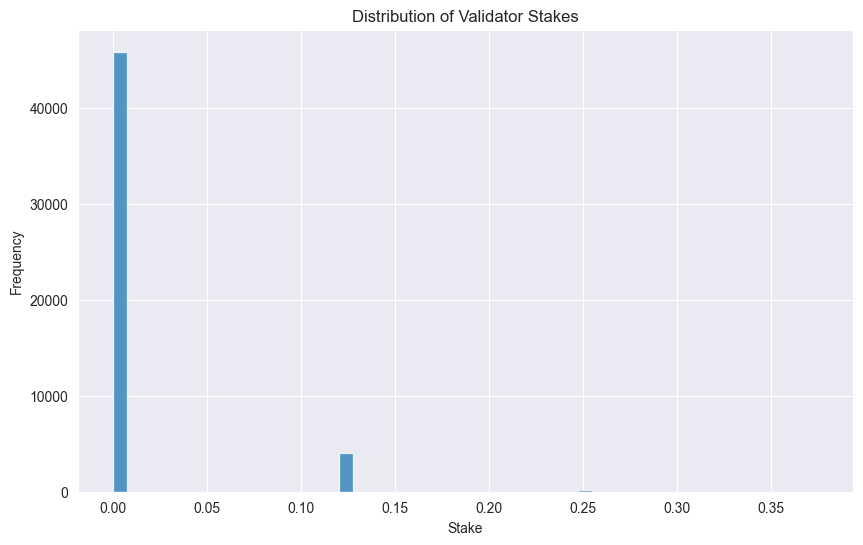

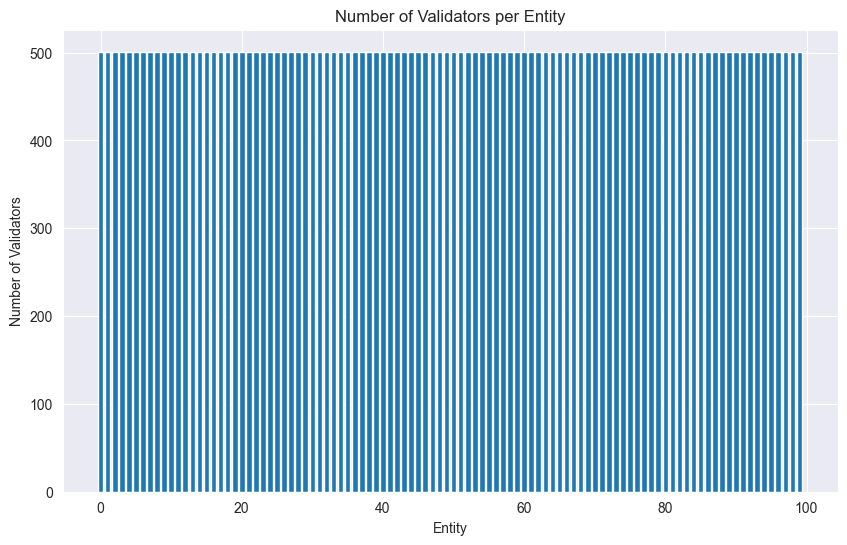

In [14]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Calculate summary statistics
num_validators = len(validator_rewards)
average_stake = np.mean(validator_rewards)
median_stake = np.median(validator_rewards)
std_dev_stake = np.std(validator_rewards)

summary_statistics = {
    "Number of validators": num_validators,
    "Average stake": average_stake,
    "Median stake": median_stake,
    "Standard deviation of stake": std_dev_stake,
}

# Print the summary statistics
print("\nSummary Statistics:")
for k, v in summary_statistics.items():
    print(f"{k}: {v}")

# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
top_stakes = [(idx, validator_rewards[idx]) for idx in sorted_indices[-20:]][::-1]
bottom_stakes = [(idx, validator_rewards[idx]) for idx in sorted_indices[:20]]

print("\nTop 20 validator stakes:")
print(tabulate(top_stakes, headers=["Validator", "Stake"]))

print("\nBottom 20 validator stakes:")
print(tabulate(bottom_stakes, headers=["Validator", "Stake"]))

# Calculate entity statistics
validators_count_per_entity = [len(validators) for validators in validators_per_entity]
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

entity_statistics = list(zip(range(num_entities), validators_count_per_entity, entity_values))

# Print the entity statistics
print("\nEntity Statistics:")
print(tabulate(entity_statistics, headers=["Entity", "Validators", "Total Value"]))

# Plot the validator stakes
plt.figure(figsize=(10, 6))
plt.hist(validator_rewards, bins=50, alpha=0.75)
plt.title('Distribution of Validator Stakes')
plt.xlabel('Stake')
plt.ylabel('Frequency')
plt.show()

# Plot the number of validators per entity
plt.figure(figsize=(10, 6))
plt.bar(range(num_entities), validators_count_per_entity)
plt.title('Number of Validators per Entity')
plt.xlabel('Entity')
plt.ylabel('Number of Validators')
plt.show()


In [13]:
# Calculate the number of validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the stats
min_val = np.min(validators_count_per_entity)
max_val = np.max(validators_count_per_entity)
median_val = np.median(validators_count_per_entity)
avg_val = np.mean(validators_count_per_entity)

# Print the stats
print("Number of validators per entity:")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Median: {median_val}")
print(f"Average: {avg_val}")

Number of validators per entity:
Minimum: 501
Maximum: 501
Median: 501.0
Average: 501.0
